In [25]:
import torch
import torchvision
from torchvision.utils import save_image

In [26]:
print ('Available devices ', torch.cuda.device_count())

Available devices  0


In [27]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
transformation = transforms.Compose([transforms.ToTensor()])
train_data_raw=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
test_data_raw=torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transformation)
train_data=DataLoader(train_data_raw,batch_size=100,shuffle=True)
test_data=DataLoader(test_data_raw,batch_size=100,shuffle=True)

In [28]:
test=next(iter(train_data))
print(test[0][0].shape)
class_names=train_data_raw.classes
print(class_names)

torch.Size([1, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [29]:
import torch.nn as nn
import torch.nn.functional as F
class Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,20,5)
        self.conv2=nn.Conv2d(20,50,5)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x: torch.Tensor):
        x=F.max_pool2d(F.relu(self.conv1(x)),2,2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2,2)
        x=x.view(-1,4*4*50)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return F.log_softmax(x,dim=1)

classifier=Classifier()


In [30]:



def train_step_classifier(classifier: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               criterion: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    classifier.train()
    
    
    # Setup train loss and train accuracy values
    train_loss=0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        
        optimizer.zero_grad()
        
        # 1. calc real loss
        y_pred = classifier(X)
        
        loss = criterion(y_pred, y)
       

        # 3. Loss backward
        loss.backward()
       
        # 4. Optimizer step for disc
        optimizer.step()
        
        #train the generator now
       
        train_loss+=loss.item()

        
       

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return train_loss

In [31]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train_class(classifier: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int = 5):
    loss_fn = nn.NLLLoss() 
    optimizer = optim.Adam(params=classifier.parameters(), lr=0.0002)
    
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step_classifier(classifier=classifier,
                                           dataloader=train_dataloader,
                                           criterion=loss_fn,
                                           optimizer=optimizer)
        
        correct=0
        total=0

        with torch.no_grad():
            classifier.eval()
            for batch, (X, y) in enumerate(test_dataloader):
                outputs = classifier(X)
      
                # Set total and correct
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == y).sum().item()
                total+=y.size(0)
        
        test_loss=(correct/total)*100
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_accuracy: {test_loss:.4f} | "
        )

        
    # 6. Return the filled results at the end of the epochs
    return results

In [32]:

# Set number of epochs
NUM_EPOCHS = 10





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
# model_results = train_class(classifier=classifier, 
#                         train_dataloader=train_data,
#                         test_dataloader=test_data,
#                         epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Total training time: 0.000 seconds


In [33]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        #encoder layers
        self.conv1=nn.Conv2d(1,20,5)
        self.conv2=nn.Conv2d(20,50,5)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        
        self.fc2=nn.Linear(500,250)
        #mu
        self.fc3=nn.Linear(250,3)
        #log_var
        self.fc4=nn.Linear(250,3)

        #decoder layers
        self.dfc1=nn.Linear(3,250)
        self.dfc2=nn.Linear(250,500)
        self.dfc3=nn.Linear(500,784)

    def encode(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2,2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2,2)
        x=x.view(-1,4*4*50)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        mu=self.fc3(x)
        var=self.fc4(x)
        return mu, var
    
    def decode(self,z):
        val=F.relu(self.dfc1(z))
        val=F.relu(self.dfc2(val))
        val=torch.sigmoid(self.dfc3(val))
        return val
    
    def sample(self, mu, var):
        deviation=torch.exp(0.5*var)
        epsilon=torch.randn_like(deviation)
        sample=torch.mul(deviation,epsilon).add_(mu) 
        return sample
    
    def forward(self,x):
        mu, var=self.encode(x)
        z=self.sample(mu=mu,var=var)
        value=self.decode(z)
        return value,mu,var

vae=VAE()
print(vae)

    


VAE(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=3, bias=True)
  (fc4): Linear(in_features=250, out_features=3, bias=True)
  (dfc1): Linear(in_features=3, out_features=250, bias=True)
  (dfc2): Linear(in_features=250, out_features=500, bias=True)
  (dfc3): Linear(in_features=500, out_features=784, bias=True)
)


In [34]:



def calc_loss(x_hat, x, mu, var, loss_fcn):
    CE_loss=F.binary_cross_entropy(x_hat,x.view(-1,784), reduction='sum')
    KL_diverge=-0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
    return CE_loss+KL_diverge

In [35]:
def train_step_VAE(model: torch.nn.Module,
                   loss_fcn: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    
    # Setup train loss and train accuracy values
    train_loss=0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        
        optimizer.zero_grad()
        
        # 1. calc real loss
        y_pred, mu, var = model(X)
        
        loss = calc_loss(y_pred, X, mu, var, loss_fcn)
       

        # 3. Loss backward
        loss.backward()
        train_loss+=loss.item()
       
        # 4. Optimizer step for disc
        optimizer.step()
        
        #train the generator now
       
        

        
       

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    return train_loss

In [36]:
# 1. Take in various parameters required for training and test steps
def train_VAE(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          epochs: int = 5):
    loss_fcn=nn.BCELoss(reduction='sum') 
    optimizer=optim.Adam(model.parameters())
    
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step_VAE(model=model,
                                           dataloader=train_dataloader,
                                           loss_fcn=loss_fcn,
                                           optimizer=optimizer)
        
        test_loss=0
     

        with torch.no_grad():
            model.eval()
            for batch, (X, y) in enumerate(test_dataloader):
               
                y_pred, mu, var = model(X)
        
                loss = calc_loss(y_pred, X, mu, var, loss_fcn)
                test_loss+=loss.item()
        
        test_loss=test_loss/len(test_dataloader)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_accuracy: {test_loss:.4f} | "
        )

        
    # 6. Return the filled results at the end of the epochs
    return results

In [37]:
NUM_EPOCHS = 100





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train_VAE(model=vae, 
                        train_dataloader=train_data,
                        test_dataloader=test_data,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 19565.0016 | test_accuracy: 17194.4602 | 
Epoch: 2 | train_loss: 15895.7881 | test_accuracy: 14754.6964 | 
Epoch: 3 | train_loss: 14380.4064 | test_accuracy: 14161.2181 | 
Epoch: 4 | train_loss: 13978.4315 | test_accuracy: 13967.1058 | 
Epoch: 5 | train_loss: 13753.0183 | test_accuracy: 13753.6557 | 
Epoch: 6 | train_loss: 13565.3587 | test_accuracy: 13494.6531 | 
Epoch: 7 | train_loss: 13424.9965 | test_accuracy: 13417.3702 | 
Epoch: 8 | train_loss: 13320.3721 | test_accuracy: 13313.0271 | 
Epoch: 9 | train_loss: 13230.5564 | test_accuracy: 13266.6808 | 
Epoch: 10 | train_loss: 13143.2329 | test_accuracy: 13208.2913 | 
Epoch: 11 | train_loss: 13069.5089 | test_accuracy: 13183.9508 | 
Epoch: 12 | train_loss: 13003.3408 | test_accuracy: 13051.3188 | 
Epoch: 13 | train_loss: 12946.8958 | test_accuracy: 12988.5144 | 
Epoch: 14 | train_loss: 12892.7827 | test_accuracy: 12950.6224 | 
Epoch: 15 | train_loss: 12846.2339 | test_accuracy: 12951.2495 | 
Epoch: 16 | train_l

In [38]:
with torch.no_grad():
    z = torch.randn(64, 3)
    sample = vae.decode(z)
    
    save_image(sample.view(64, 1, 28, 28), './vae_samples/sample_' + '.png')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cm.py:496: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


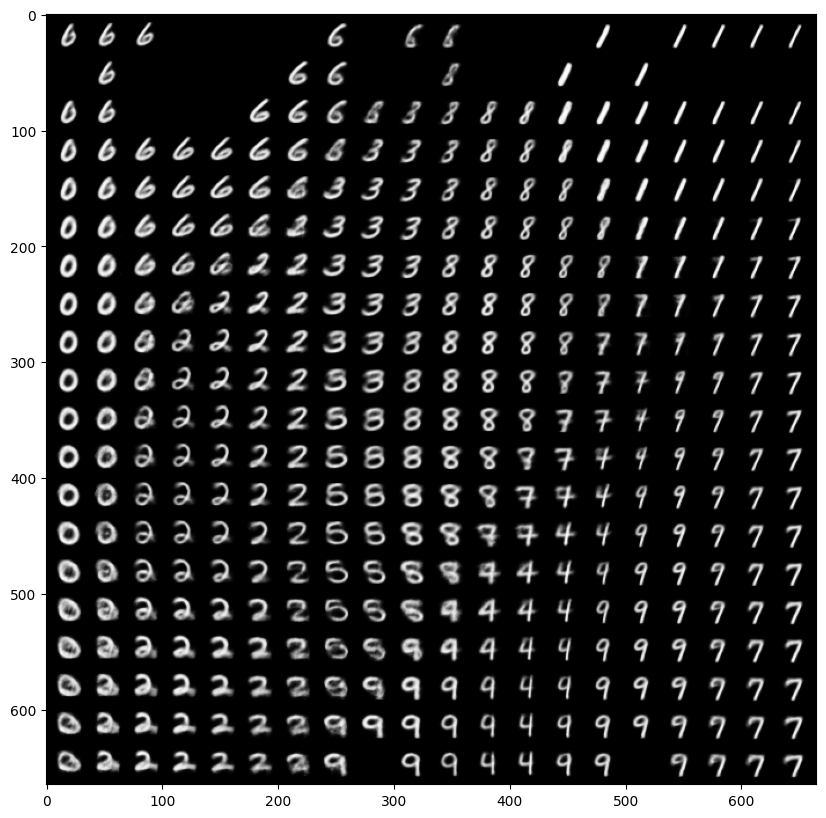

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
device='cpu'
with torch.no_grad():
  # Create empty (x, y) grid
  latent_x = np.linspace(-1.5, 1.5, 20)
  latent_y = np.linspace(-1.5, 1.5, 20)
  latents = torch.FloatTensor(len(latent_x), len(latent_y), 3)
  # Fill up the grid
  for i, lx in enumerate(latent_x):
    for j, ly in enumerate(latent_y):
      latents[j, i, 0] = lx
      latents[j, i, 1] = ly
  # Flatten the grid
  latents = latents.view(-1, 3)
  # Send to GPU
  latents = latents.to(device)
  # Find their representation
  reconstructions = vae.decode(latents).view(-1, 1, 28, 28)
  reconstructions = reconstructions.cpu()
  # Finally, plot
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.imshow(np.transpose(make_grid(reconstructions.data[:400], 20, 5).clamp(0, 1).numpy(), (1, 2, 0))) 